In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

web_search = TavilySearchResults(max_results=2)
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart"] ):
    """Use this to execute python code. If you want to see the output of a value, 
    you should print it out with 'print(...)'. chart labels should be written in English.
    This is visible to user."""

    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Fail to execute. Error{repr(e)}"
    result_str = f"Successfully executed:\n'''python\n{code}\n'''\nStdout: {result}"
    return (result_str + "\n\nIf you hav completed all tasks, respond with FINAL ANSWER.")
tools = [web_search, python_repl]
tool_node = ToolNode(tools)

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def agent(state: State):
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}

In [7]:
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [11]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(State)
workflow.add_node("agent", agent)
workflow.add_node("tool", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue":"tool",
        "end":END
    },
)
workflow.add_edge("tool", "agent")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory, interrupt_before=["tool"])

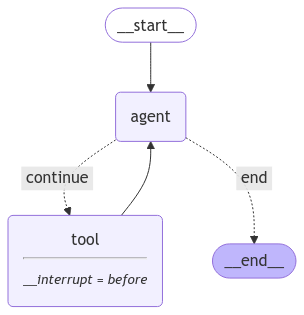

In [12]:
from util import display_graph
display_graph(app)

In [19]:
initial_input = {"messages": [HumanMessage(content="미국의 최근 5개년(~2023) GDP 차트를 그려줄래?")]}
thread = {"configurable": {"thread_id": "11"}}
async for chunk in app.astream(initial_input, thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")


Receiving update from node: 'agent'
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1AyKXTXvdm1r6y1R1HwehFCE', 'function': {'arguments': '{"query":"US GDP data for the past 5 years 2019-2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 167, 'total_tokens': 200, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fa380eec-2ac3-46fe-be25-79b6641ca64a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'US GDP data for the past 5 years 2019-2023'}, 'id': 'call_1AyKXTXvdm1r6y1R1HwehFCE', 'type': 'tool_call'}], usage_metadata={'input_tok

In [20]:
# intterupt 되서 멈춘 thread를 이어 실행 (None)
async for chunk in app.astream(None, thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")


Receiving update from node: 'tool'
{'messages': [ToolMessage(content='[{"url": "https://www.macrotrends.net/global-metrics/countries/USA/united-states/gdp-growth-rate", "content": "U.S. GDP Growth Rate 1961-2024 | MacroTrends U.S. GDP Growth Rate 1961-2024 GDP Growth Rate Annual percentage growth rate of GDP at market prices based on constant local currency. U.S. gdp growth rate for 2023 was 2.54%, a 0.61% increase from 2022. U.S. gdp growth rate for 2022 was 1.94%, a 3.86% decline from 2021. U.S. gdp growth rate for 2021 was 5.80%, a 8.01% increase from 2020. U.S. gdp growth rate for 2020 was -2.21%, a 4.68% decline from 2019. | Country Name | GDP Growth (%) | | U.S. GDP Growth Rate - Historical Data | | U.S. GDP Growth Rate 1961-2024 |  | | U.S. GDP Growth Rate 1961-2024 |  |"}, {"url": "https://www.macrotrends.net/global-metrics/countries/USA/united-states/gdp-gross-domestic-product", "content": "| 2023 | $27,360.94B | $81,695 | 2.54% | | 2022 | $25,744.11B | $77,247 | 1.94% | | 202

In [21]:
# intterupt 되서 멈춘 thread를 이어 실행 (None)
async for chunk in app.astream(None, thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")


Python REPL can execute arbitrary code. Use with caution.


Receiving update from node: 'tool'
{'messages': [ToolMessage(content='Successfully executed:\n\'\'\'python\nimport matplotlib.pyplot as plt\n\n# US GDP data from 2019 to 2023\nyears = [2019, 2020, 2021, 2022, 2023]\ngdp_values = [21521.40, 21322.95, 23594.03, 25744.11, 27360.94]  # in billion USD\n\nplt.figure(figsize=(10, 5))\nplt.plot(years, gdp_values, marker=\'o\')\nplt.title(\'US GDP from 2019 to 2023\')\nplt.xlabel(\'Year\')\nplt.ylabel(\'GDP (in Billion USD)\')\nplt.xticks(years)\nplt.grid()\nplt.show()\n\'\'\'\nStdout: ModuleNotFoundError("No module named \'matplotlib\'")\n\nIf you hav completed all tasks, respond with FINAL ANSWER.', name='python_repl', id='7f5bce13-36a9-47f6-8598-2cbbea2130dc', tool_call_id='call_BVSteJIkPMnjtNbGAH7j0j0q')]}



Receiving update from node: 'agent'
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CuoYjnNKrzvHYCP2OQkYsnE0', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# US GDP data fr

In [22]:
# intterupt 되서 멈춘 thread를 이어 실행 (None)
async for chunk in app.astream(None, thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")


Receiving update from node: 'tool'
{'messages': [ToolMessage(content='Successfully executed:\n\'\'\'python\nimport matplotlib.pyplot as plt\n\n# US GDP data from 2019 to 2023\nyears = [2019, 2020, 2021, 2022, 2023]\ngdp_values = [21521.40, 21322.95, 23594.03, 25744.11, 27360.94]  # in billion USD\n\nplt.figure(figsize=(10, 5))\nplt.plot(years, gdp_values, marker=\'o\')\nplt.title(\'US GDP from 2019 to 2023\')\nplt.xlabel(\'Year\')\nplt.ylabel(\'GDP (in Billion USD)\')\nplt.xticks(years)\nplt.grid()\nplt.show()\n\'\'\'\nStdout: ModuleNotFoundError("No module named \'matplotlib\'")\n\nIf you hav completed all tasks, respond with FINAL ANSWER.', name='python_repl', id='9d7a2c2c-9fc8-4608-957b-62da8220c6ae', tool_call_id='call_CuoYjnNKrzvHYCP2OQkYsnE0')]}



Receiving update from node: 'agent'
{'messages': [AIMessage(content='최근 5개년(2019-2023) 미국의 GDP 데이터를 기반으로 한 차트를 생성할 수 없는 상황입니다. 그러나 아래의 GDP 수치를 제공해 드릴 수 있습니다.\n\n- **2019년:** 21,521.40억 달러\n- **2020년:** 21,322.95억 달러\n- **2021년:** 23,59